In [17]:
# Code+ Campus Space & Energy Project
# Dates: May 21-22, 2024.
# Team member: Adeildo Vieira

### DOCUMENT 1: First analysis on the ph_sample.csv dataset.

            # Goals for now:
                # Sort all;
                # Make a private key # to identify equal NetIDs and Mac Address.
                    # Such as: NetID 9r3fsa = 1; NetID 3s1obb = 2; and so on.
                # Analyze number of people and frequency in those rooms in general.
                    # Are they frequently there for a moment? For a long time? =>
                    # Is this specific room unoccupied for a long period of time?
                    # Additional goal for the future:
                        # -> Make the predictive model act 2-5 minutes before people are coming in,
                        # -> to make the room comfortable.

#### Essential Steps:
# Using Pandas to read the .csv.
import pandas as pd

# Reading the 300 Fuller building sample.
fuller_sample = pd.read_csv('phsample.csv')
#print(fuller_sample.to_string())


#### Organizing our Dataset:
### Columns: _time, ap_name, netid, ssid, assoc, macaddr

### 1. Sorting:
## O(row * column) complexity => Probably O(row log(row)) // O(N log(N) here.

# Sorting.
## Same timezone for all the available data, so ignoring it for now.
fuller_sample['_time'] = pd.to_datetime(fuller_sample['_time']).dt.tz_localize(None)
fuller_sample_sorted = fuller_sample.sort_values(by=['_time', 'ap_name', 'netid', 'ssid'])

# Checking and saving.
#print(fuller_sample_sortedbydate.to_string())
fuller_sample_sorted.to_csv('sorted_phsample.csv', index=False)

### 2. For how many people there're in each room: Making NetID unique and 'keyed' with #s instead of encrypted data.
## O(row) complexity => O(N) - Linear or at least amortized (depending on: they're all filled with netids or there's some with no netid).

# Net ID and Mac Addresses map (their key #s are independent from each other):
netid_map = {netid: idx + 1 for idx, netid in enumerate(fuller_sample_sorted['netid'].unique())}
fuller_sample_sorted['netid'] = fuller_sample_sorted['netid'].map(netid_map)

macaddr_map = {macaddr: idx + 1 for idx, macaddr in enumerate(fuller_sample_sorted['macaddr'].unique())}
fuller_sample_sorted['macaddr'] = fuller_sample_sorted['macaddr'].map(macaddr_map)

# Saving the dataset with private data relay:
fuller_sample_sorted.to_csv('sorted_private_phsample.csv', index=False)


#### DATA ANALYSIS:

# First: How many individuals were there, based on the dataset:
phsample_ppl_count = fuller_sample_sorted['netid'].nunique()

# Second: Visits per room per individual. What's the maximum # of individuals that have been in a room?
visits_per_room = fuller_sample_sorted.groupby(['ap_name', 'netid']).size().reset_index(name='visit_count')
max_visits = visits_per_room['visit_count'].max()

# Third: Who visits each room the most?
idx = visits_per_room.groupby('ap_name')['visit_count'].idxmax()
most_visits_per_room = visits_per_room.loc[idx].reset_index(drop=True)

# Forth: Who's the second to visit each room the most?
visits_per_room_sorted = visits_per_room.sort_values(by=['ap_name', 'visit_count'], ascending=[True, False])
second_most_visits_per_room = visits_per_room_sorted.groupby('ap_name').nth(1).reset_index()

# Fifth: Who's the third one?
third_most_visits_room = visits_per_room_sorted.groupby('ap_name').nth(2).reset_index()

## Visualizing 1:
print(f'Number of unique individuals: {phsample_ppl_count}')
print('Visits per room per individual:')
print(visits_per_room)
print(f'Maximum number of visits by an individual in a room: {max_visits}')
print('Individual with the most visits per room:')
print(most_visits_per_room)
print('Individual with the second most visits per room:')
print(second_most_visits_per_room)
print('Individual with the third most visits per room:')
print(third_most_visits_room)

## Saving 1:
visits_per_room.to_csv('visits_per_room_per_individual.csv', index=False)
most_visits_per_room.to_csv('most_visits_per_room.csv', index=False)
second_most_visits_per_room.to_csv('second_most_visits_per_room.csv', index=False)
third_most_visits_room.to_csv('third_most_visits_room.csv', index=False)

Number of unique individuals: 189
Visits per room per individual:
                        ap_name  netid  visit_count
0    300fuller-101b-cw9166-rw-1      1          145
1    300fuller-101b-cw9166-rw-1      2           25
2    300fuller-101b-cw9166-rw-1      3            1
3    300fuller-101b-cw9166-rw-1      4           12
4    300fuller-101b-cw9166-rw-1      5            9
..                          ...    ...          ...
446   300fuller-116-cw9166-hc-1    173            1
447   300fuller-116-cw9166-hc-1    175            2
448   300fuller-116-cw9166-hc-1    176            1
449   300fuller-116-cw9166-hc-1    184            1
450   300fuller-116-cw9166-hc-1    185            1

[451 rows x 3 columns]
Maximum number of visits by an individual in a room: 228
Individual with the most visits per room:
                       ap_name  netid  visit_count
0   300fuller-101b-cw9166-rw-1      1          145
1  300fuller-101b-cw9166i-rw-2      1           95
2    300fuller-104-cw9166-hc-1    

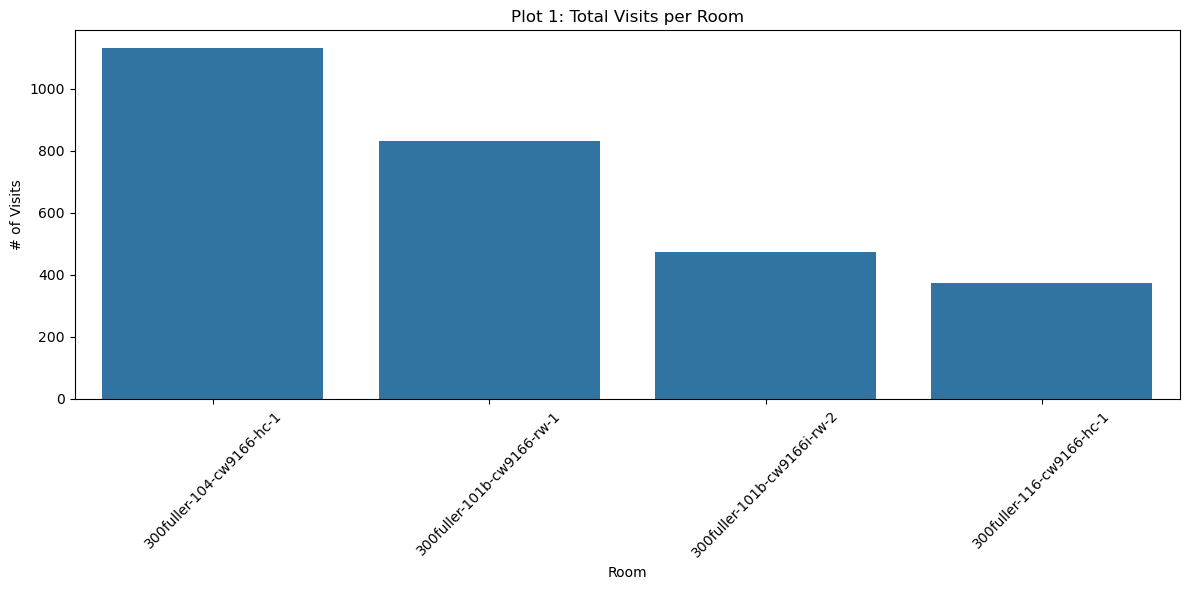

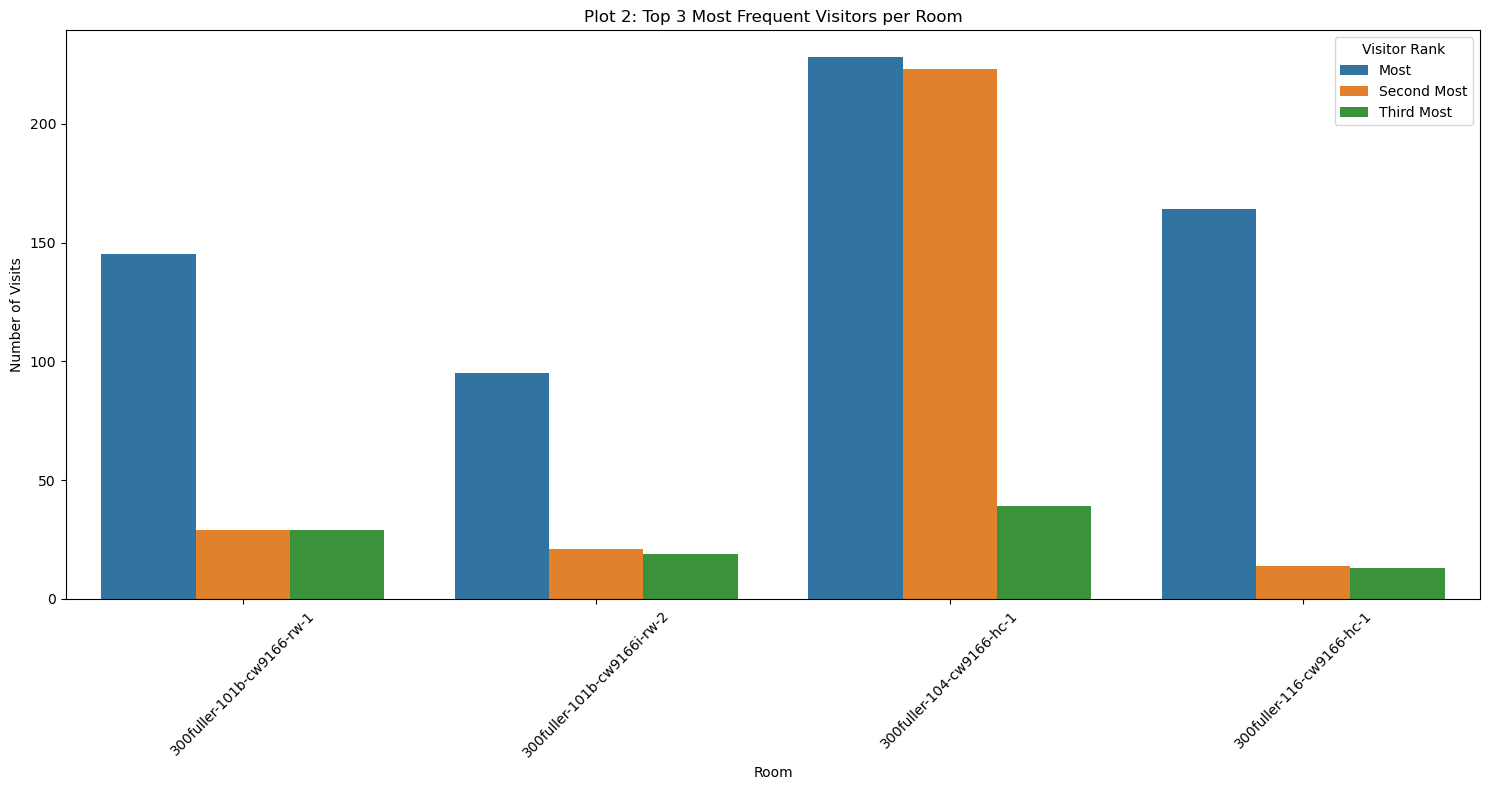

In [15]:
### Analysis on the studied data:
## As of now, we are able to see some insights.
# 1. 189 people visited these rooms, but just one person '1' with some private NetID '1' made 228 visits
#    in a room. In second place, there's some person '27' who made 223 visits. Third place, person '6' who
#    made just 39 visits. A drop pattern on visits is happening in all the 5 studied rooms.

### Visualizing the so-far data:

import matplotlib.pyplot as plt
import seaborn as sns

# TOTAL VISITS PER ROOM:
plt.figure(figsize=(12, 6))
sns.countplot(data=fuller_sample_sorted, x='ap_name', order=fuller_sample_sorted['ap_name'].value_counts().index)
plt.title('Plot 1: Total Visits per Room')
plt.xlabel('Room')
plt.ylabel('# of Visits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('total_visits_per_room.png')
plt.show()

# 1st, 2nd, and 3rd most FREQUENT VISITOR PER ROOM:
most_visits_per_room['rank'] = 'Most'
second_most_visits_per_room['rank'] = 'Second Most'
third_most_visits_room['rank'] = 'Third Most'

combined_visits = pd.concat([most_visits_per_room, second_most_visits_per_room, third_most_visits_room])
combined_visits = combined_visits.sort_values(by=['ap_name', 'rank'])

plt.figure(figsize=(15, 8))
sns.barplot(data=combined_visits, x='ap_name', y='visit_count', hue='rank')
plt.title('Plot 2: Top 3 Most Frequent Visitors per Room')
plt.xlabel('Room')
plt.ylabel('Number of Visits')
plt.xticks(rotation=45)
plt.legend(title='Visitor Rank')
plt.tight_layout()
plt.savefig('top3_visits_per_room.png')
plt.show()

In [ ]:
### Analysis of Plot 1 and 2:

## Based on both visualization, it is expressed that, in those 5 rooms, only 3 people make most of the visits there.
## For further analysis: If we know these rooms are large, and the A/C or heater is in full capacity mode, and there's
##                       just 3 frequent people for some period of time, then, the A/C or heater could be powered only
##                       to make 1-3 people in a comfortable environment.

## In the next documents: Some questions will be studied:
### 2. How many people are in each room by period of time (using '_time', 'netid', and 'assoc' only)?
### 3. When is each room unoccupied for a long period of time? (Considering that printers, and permanent PCs are isolated in the plots).

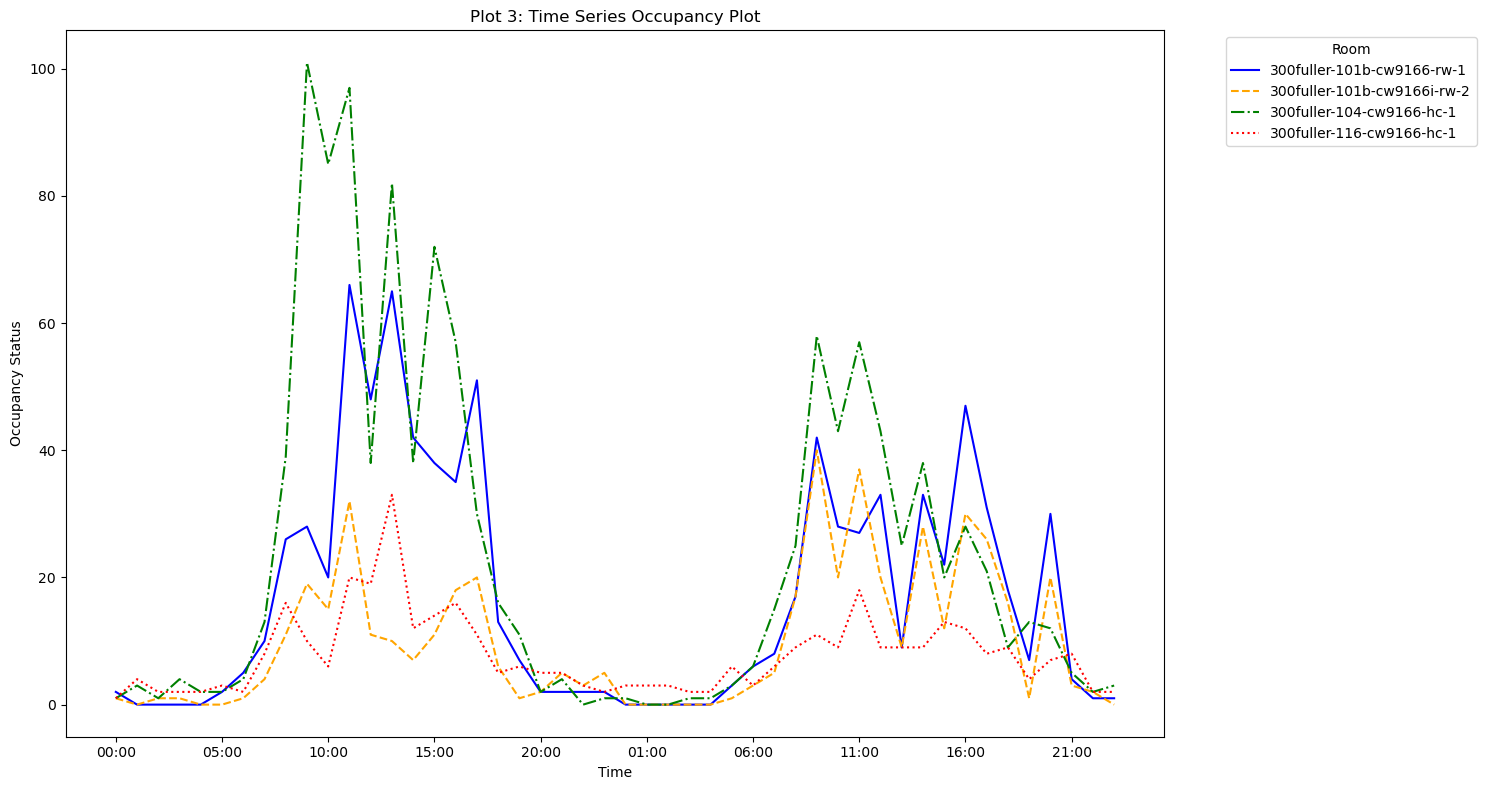

In [39]:
# Code+ Campus Space & Energy Project
# Dates: May 22-23, 2024.
# Team member: Adeildo Vieira

### DOCUMENT 2: Further anaylsis on the ph_sample.csv dataset.

import matplotlib.dates as mdates

## 2. How many people are in each room by period of time (using '_time', 'netid', and 'assoc' only)?
occ_data = fuller_sample_sorted.groupby([pd.Grouper(key='_time', freq='h'), 'ap_name']).size().unstack(fill_value=0)
occ_status = occ_data.apply(lambda x: x.map(lambda y: 1 if y > 0 else 0))

plt.figure(figsize=(15, 8))

line_styles = ['-', '--', '-.', ':']
colors = ['blue', 'orange', 'green', 'red']

# for room in occ_status.columns:
#     plt.plot(occ_status.index, occupancy_status[room], label=room)

for i, room in enumerate(occupancy_data.columns):
    plt.plot(occupancy_data.index, occupancy_data[room], label=room, linestyle=line_styles[i % len(line_styles)], color=colors[i % len(colors)])

plt.title('Plot 3: Time Series Occupancy Plot')
plt.xlabel('Time')
plt.ylabel('Occupancy Status')
plt.gca().invert_yaxis() # Vacant was being shown as the greater values.
plt.legend(title='Room', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=5)) # Now showing X within 1 hour intervals.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('time_series_occupancy_plot.png')
plt.show()

In [ ]:
## On plot 3, it is important to notice that these 4 rooms have the same occupancy behavior per hour, even though those happen in different quantities.
## With a similar behavior, we can let this question be there for next greater data sets and prediction: All rooms have a similar behavior? Most of them?

In [41]:
## Sketch for further analysis // p-value:

from scipy.stats import f_oneway

occ_grps = [occupancy_data[room].dropna() for room in occupancy_data.columns]
result = f_oneway(*occ_grps)

p_vl = anova_result.pvalue
print(f'P-value: {p_vl}')

P-value: 6.251058096332477e-05


In [ ]:
# p < 0.05; p = 6.25 ^ e-05 <=> p = 0.0000625.
# Strong association. These 5 rooms have significantly different occupancy levels compared to others.
# Null hypothesis rejected.